In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
scaler=MinMaxScaler()
df=pd.read_csv("daily")

In [2]:
# FUNCTIONS

def categorise(x):
    return x.astype("category")

In [3]:
clean_df=df.copy(deep=True)
x=["month", "weekday", "workingday", "weather", "clean_df", 
        "cnt", "hum", "windspeed", "temp", "season", "holiday"]
a=clean_df.columns
a=[i for i in a if i not in x]
clean_df.drop(a, axis=1, inplace=True)
clean_df["month"]=categorise(clean_df["month"])
clean_df["weekday"]=categorise(clean_df["weekday"])
clean_df["workingday"]=categorise(clean_df["workingday"])
clean_df["weather"]=categorise(clean_df["weather"])
clean_df["holiday"]=categorise(clean_df["holiday"])
clean_df["season"]=categorise(clean_df["season"])

In [4]:
temp=pd.get_dummies(clean_df, drop_first=True)
np.random.seed(0)
train, test = train_test_split(temp, train_size=0.7, test_size=0.3,
            random_state=333)

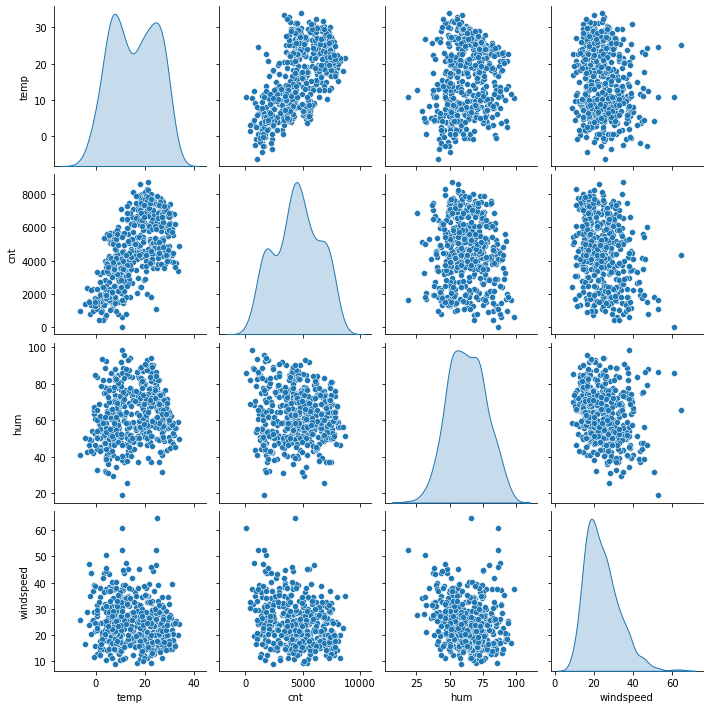

In [5]:
x=train[["temp", "cnt", "hum", "windspeed"]]
sns.pairplot(x, diag_kind="kde")

<AxesSubplot:xlabel='holiday', ylabel='cnt'>

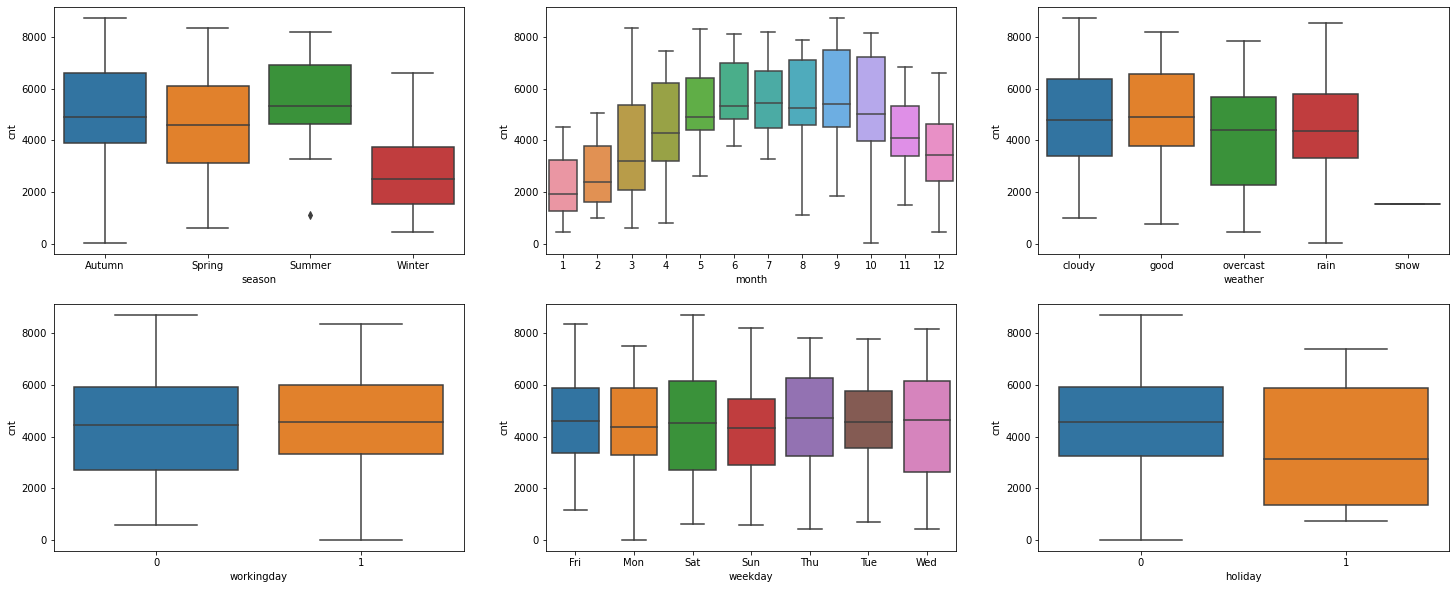

In [6]:
plt.figure(figsize=(25,10))
plt.subplot(2,3,1)
sns.boxplot(x="season", y="cnt", data=clean_df)
plt.subplot(2,3,2)
sns.boxplot(x="month", y="cnt", data=clean_df)
plt.subplot(2,3,3)
sns.boxplot(x="weather", y="cnt", data=clean_df)
plt.subplot(2,3,4)
sns.boxplot(x="workingday", y="cnt", data=clean_df)
plt.subplot(2,3,5)
sns.boxplot(x="weekday", y="cnt", data=clean_df)
plt.subplot(2,3,6)
sns.boxplot(x="holiday", y="cnt", data=clean_df)

<AxesSubplot:>

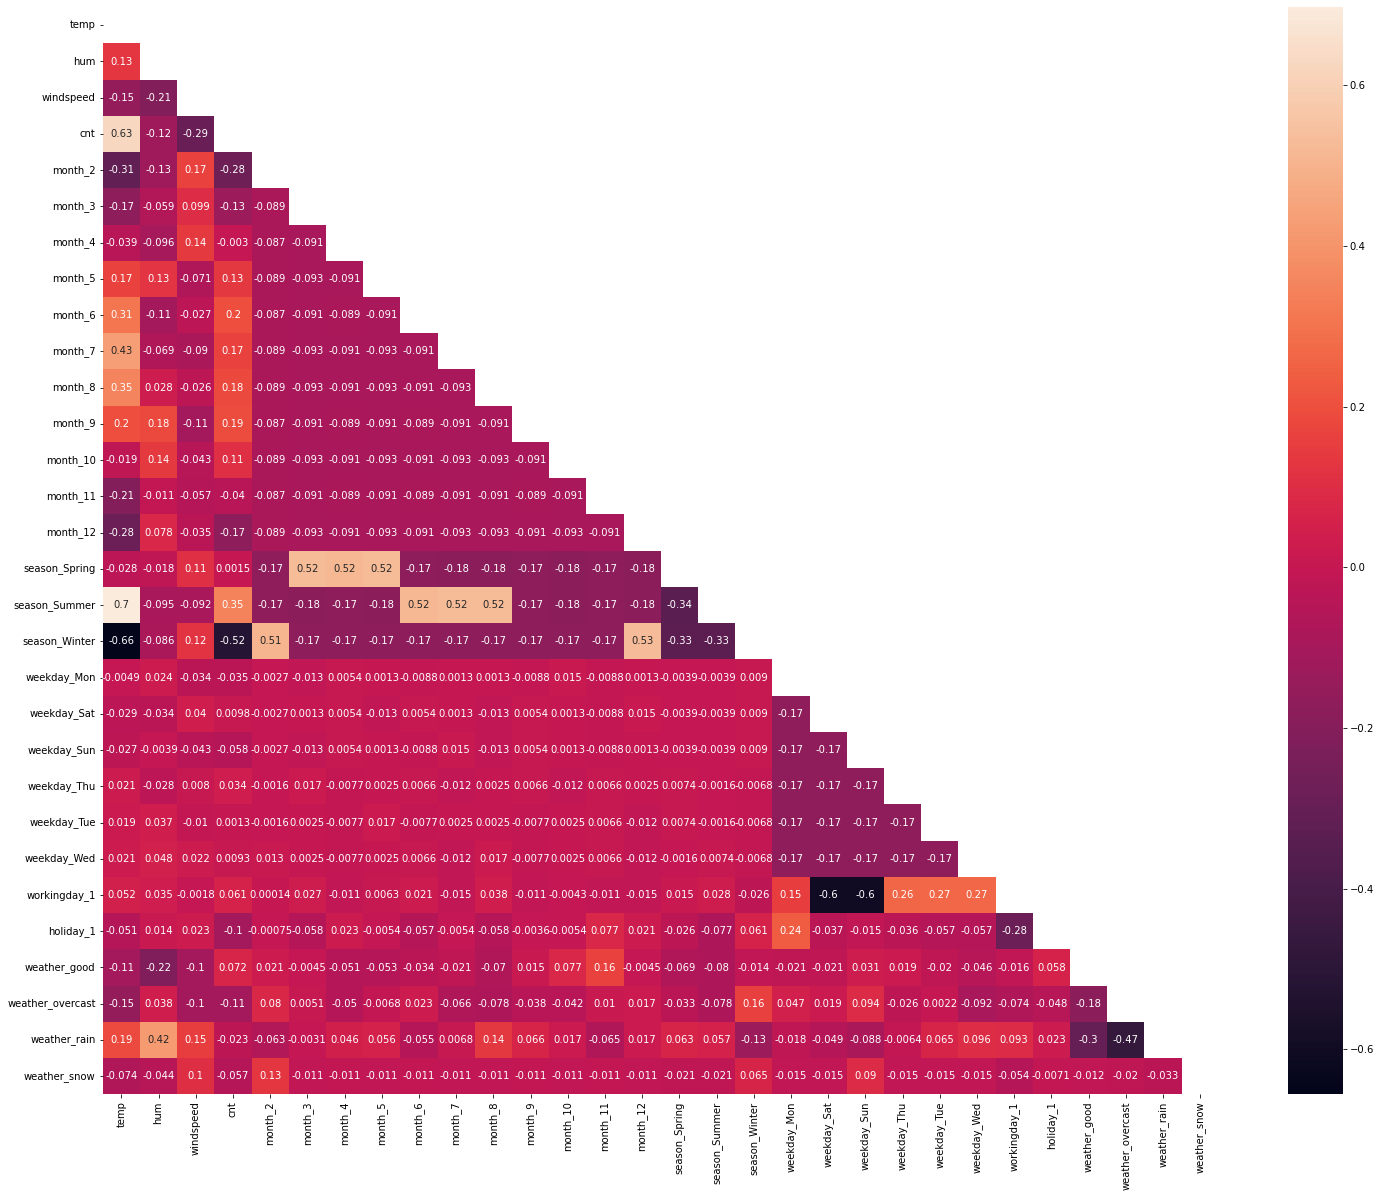

In [7]:
plt.figure(figsize=(25,20))
matrix=np.triu(temp.corr())
sns.heatmap(temp.corr(), annot=True, mask=matrix)

In [8]:
a=["temp", "hum", "windspeed", "cnt"]
train[a]=scaler.fit_transform(train[a])

In [9]:
ytrain=train.pop("cnt")
xtrain=train

In [10]:
lm=LinearRegression()
lm.fit(xtrain, ytrain)
rfe=RFE(lm, n_features_to_select=15)
rfe=rfe.fit(xtrain, ytrain)
list(zip(xtrain.columns, rfe.support_, rfe.ranking_))

[('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('month_2', False, 13),
 ('month_3', True, 1),
 ('month_4', True, 1),
 ('month_5', True, 1),
 ('month_6', True, 1),
 ('month_7', True, 1),
 ('month_8', True, 1),
 ('month_9', True, 1),
 ('month_10', True, 1),
 ('month_11', True, 1),
 ('month_12', False, 2),
 ('season_Spring', True, 1),
 ('season_Summer', True, 1),
 ('season_Winter', True, 1),
 ('weekday_Mon', False, 7),
 ('weekday_Sat', False, 4),
 ('weekday_Sun', False, 12),
 ('weekday_Thu', False, 11),
 ('weekday_Tue', False, 9),
 ('weekday_Wed', False, 8),
 ('workingday_1', False, 5),
 ('holiday_1', False, 15),
 ('weather_good', False, 6),
 ('weather_overcast', False, 14),
 ('weather_rain', False, 10),
 ('weather_snow', False, 3)]

In [11]:
col=xtrain.columns[rfe.support_]
xtrain_rfe=xtrain[col]

In [12]:
vif=pd.DataFrame()
vif["feature"]=xtrain_rfe.columns
vif["vif"]=[variance_inflation_factor(xtrain_rfe.values, i) for i in 
        range(xtrain_rfe.shape[1])]
vif["vif"]=round(vif["vif"],2)
vif=vif.sort_values(by="vif", ascending=False)
vif

,feature,vif
3,month_3,inf
4,month_4,inf
5,month_5,inf
6,month_6,inf
7,month_7,inf
8,month_8,inf
12,season_Spring,inf
13,season_Summer,inf
14,season_Winter,6.66
9,month_9,5.88


Test with simpler model

In [17]:
from sklearn import datasets, linear_model, metrics

In [ ]:
boston=datasets.load_boston(return_X_y=False)
x=boston.data
y=boston.target


Coeffictients: [-8.95714048e-02  6.73132853e-02  5.04649248e-02  2.18579583e+00
 -1.72053975e+01  3.63606995e+00  2.05579939e-03 -1.36602886e+00
  2.89576718e-01 -1.22700072e-02 -8.34881849e-01  9.40360790e-03
 -5.04008320e-01]
Variance score:0.7209056672661754


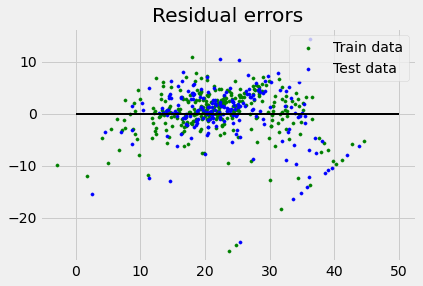

In [46]:
xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size=0.4,
            random_state=1)
reg=linear_model.LinearRegression()
reg.fit(xtrain, ytrain)
print("Coeffictients:", reg.coef_)
print("Variance score:{}".format(reg.score(xtest, ytest)))
plt.style.use("fivethirtyeight")
plt.scatter(reg.predict(xtrain), reg.predict(xtrain)-ytrain,
            color="green", s=10, label="Train data")
plt.scatter(reg.predict(xtest), reg.predict(xtest)-ytest,
            color="blue", s=10, label="Test data")
plt.hlines(y=0, xmin=0, xmax=50, linewidth=2, color="black")
plt.legend(loc="upper right")
plt.title("Residual errors")
plt.show()

In [13]:
def estimator(x, y):
    n=np.size(x)
    mx=np.mean(x)
    my=np.mean(y)
    ssxy=np.sum(y*x)-n*my-mx
    ssxx=np.sum(x*x)-n*mx*mx
    b1=ssxy/ssxx
    b0=my-b1*mx
    return(b0,b1)
def liner(x, y, b):
    plt.scatter(x, y, color="m", marker="o", s=30)
    y_pred=b[0]+b[1]*x
    plt.plot(x, y_pred, colog="g")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
def main(x):
    x

In [100]:
clean_df=df.copy(deep=True)
x=["month", "weekday", "workingday", "weather", "clean_df", 
        "cnt", "hum", "windspeed", "temp", "season", "holiday"]
a=clean_df.columns
a=[i for i in a if i not in x]
clean_df.drop(a, axis=1, inplace=True)
clean_df["season"].replace({"Winter":0,"Spring":1,"Summer":2,
                        "Autumn":3}, inplace=True)
clean_df["weekday"].replace({"Sun":0,"Mon":1,"Tue":2,"Wed":3,"Thu":4,
                                "Fri":5,"Sat":6}, inplace=True)
clean_df["weather"].replace({"good":0,"cloudy":1,"overcast":2,"rain":3,
                                "snow":4}, inplace=True)
clean_df["month"]=categorise(clean_df["month"])
clean_df["weekday"]=categorise(clean_df["weekday"])
clean_df["workingday"]=categorise(clean_df["workingday"])
clean_df["weather"]=categorise(clean_df["weather"])
clean_df["holiday"]=categorise(clean_df["holiday"])
clean_df["season"]=categorise(clean_df["season"])
x=(clean_df.drop(["cnt"], axis=1)).to_numpy(copy=True)
y=(clean_df["cnt"]).to_numpy(copy=True)

In [114]:
clean_df=df.copy(deep=True)
x=["month", "weekday", "workingday", "weather", "clean_df", 
        "cnt", "temp", "season", "holiday"]
a=clean_df.columns
a=[i for i in a if i not in x]
clean_df.drop(a, axis=1, inplace=True)
clean_df["season"].replace({"Winter":0,"Spring":1,"Summer":2,
                        "Autumn":3}, inplace=True)
clean_df["weekday"].replace({"Sun":0,"Mon":1,"Tue":2,"Wed":3,"Thu":4,
                                "Fri":5,"Sat":6}, inplace=True)
clean_df["weather"].replace({"good":0,"cloudy":1,"overcast":2,"rain":3,
                                "snow":4}, inplace=True)
clean_df["month"]=categorise(clean_df["month"])
clean_df["weekday"]=categorise(clean_df["weekday"])
clean_df["workingday"]=categorise(clean_df["workingday"])
clean_df["weather"]=categorise(clean_df["weather"])
clean_df["holiday"]=categorise(clean_df["holiday"])
clean_df["season"]=categorise(clean_df["season"])
x=(clean_df.drop(["cnt"], axis=1)).to_numpy(copy=True)
y=(clean_df["cnt"]).to_numpy(copy=True)

Coefficients: [  44.39340349  260.34564502   84.36902069   44.69350698 -389.49986276
 -346.560232    109.32398016]
Variance score:0.5163455026125174


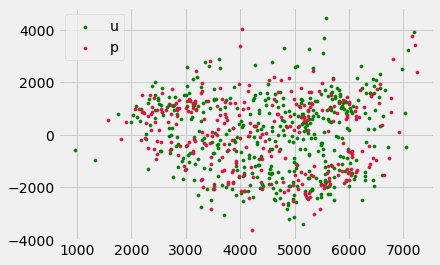

In [119]:
xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size=0.4,
                                                random_state=1)
reg=LinearRegression()
reg.fit(xtrain, ytrain)
print("Coefficients:", reg.coef_)
print("Variance score:{}".format(reg.score(xtest, ytest)))
plt.style.use("fivethirtyeight")
plt.scatter(reg.predict(xtrain), reg.predict(xtrain)-ytrain,
            color="green", s=10, label="Train data")
plt.scatter(reg.predict(xtest), reg.predict(xtest)-ytest,
            color="crimson", s=10, label="Test data")
plt.legend("upper right")
plt.show()